In [1]:
# Check the calculation of the THG, as a function of thermodynamic parameters,
# without runninga a time-evolution for a specific experiment.

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import multiprocessing as mp

In [3]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [4]:
from models.cooling_phonons_v3 import CoolingPhonons
from models.graphene_optics import GrapheneTHG
import models.graphene_thermodynamics_v2 as gt

In [5]:
# Create save folder.
run_label = "parametric"
time_stamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
saveDir = "./data/03/%s_%s" % (time_stamp, run_label)
os.mkdir(saveDir)

In [6]:
params = {
    "pr_fluenceSI": 110.0,
    "pr_dt": 150.0,
    "pr_eph": 0.5, # 0.320,
    "nsub": 1.4,  # was 2.0
    "ntop": 1.4,  # was 2.0
    "gammaConst": 0.0,
    "gammaProp": 0.0, #0.55,
    "gammaInv": 0.0, #0.018
}
# Convert fluence SI [uJ/cm^-2] to [eV / nm^2].
params["pr_fluence"] = params["pr_fluenceSI"] * 0.062
# Calculate power density [eV / fs nm^2].
params["pr_powdens"] = params["pr_fluence"] / params["pr_dt"]
# Prepare the object to calculate the THG efficiency.
thg = GrapheneTHG(nsub=params["nsub"], ntop=params["ntop"], eph=params["pr_eph"],
                  maldagueMin=0.001, maldagueMax=2.0, maldagueNum=301)
thg.coeffGamma(gammaConst=params["gammaConst"], gammaProp=params["gammaProp"], gammaInv=params["gammaInv"])

In [7]:
# Save parameters as JSON file.
with open("%s/params.json" % saveDir, "w") as f:
    json.dump(params, f, indent=4)

# Check integrand and Maldague mesh

THG = 2.253300e-10


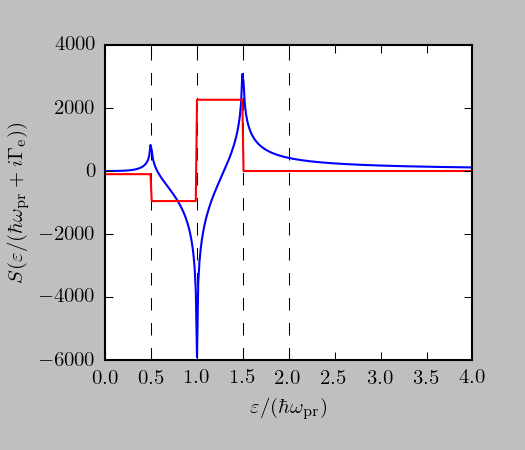

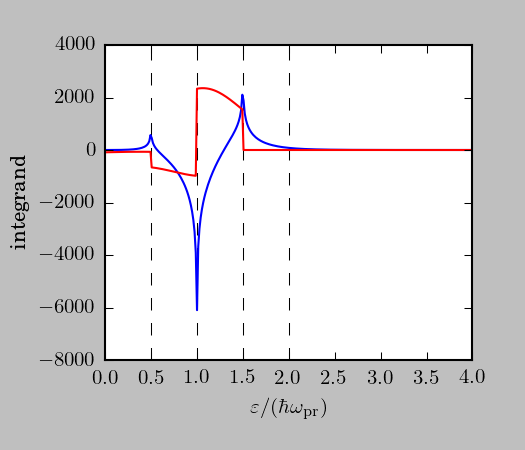

In [33]:
# Fermi energy [eV].
eF = 1.2 * params["pr_eph"]
# Electron temperature [K].
tempK = 1800.0
# Photoexcited density [nm^-2].
dnE = 0.01
# Calculate electron density [nm^-2].
dens = gt.twobands_dens_ef_func(eF)
# Calculate the chemical potential.
muC, muV = gt.photoexc_mu_func(dens, dnE, tempK)
# Calculate eta.
thg.calculate_eta(powdens=params["pr_powdens"], muC=muC, muV=muV, tempK=tempK)
print("THG = %e" % thg.p["eta"])


mpl.style.use(["classic", "latex"])
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for x0 in [0.5, 1.0, 1.5, 2.0]:
    plt.axvline(x0, ls="--", c="black", lw=0.5)
plt.plot(thg.eMesh / params["pr_eph"], np.real(thg.ss), "-b")
plt.plot(thg.eMesh / params["pr_eph"], np.imag(thg.ss), "-r")
plt.xlabel(r"$\varepsilon / (\hbar \omega_{\rm pr})$")
plt.ylabel(r"$S(\varepsilon / (\hbar \omega_{\rm pr} + i \Gamma_{\rm e}))$");


mpl.style.use(["classic", "latex"])
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for x0 in [0.5, 1.0, 1.5, 2.0]:
    plt.axvline(x0, ls="--", c="black", lw=0.5)
plt.plot(thg.eMesh / params["pr_eph"], np.real(thg.yy), "-b")
plt.plot(thg.eMesh / params["pr_eph"], np.imag(thg.yy), "-r")
plt.xlabel(r"$\varepsilon / (\hbar \omega_{\rm pr})$")
plt.ylabel(r"integrand");

# THG vs Fermi energy at various temperatures, zero photoexcited density

In [8]:
# List of Fermi energies, defined wrt the probe photon energy.
eF_rel_list = np.linspace(0.1, 2.0, 101)
eF_list = params["pr_eph"] * eF_rel_list
# List of temperatures.
tempK_list = np.array([77.0, 300.0, 900.0, 1200.0, 1800.0])

In [9]:
# Calculate THG efficiency for all temperatures and Fermi energies.
etaTHG = np.zeros((len(eF_list),len(tempK_list)))
# Iterate over temperature and Fermi energy.
for itempK,tempK in enumerate(tempK_list):
    for ieF,eF in enumerate(eF_list):
        # Calculate electron density [nm^-2].
        dens = gt.twobands_dens_ef_func(eF)
        # Calculate the chemical potential.
        mu = gt.twobands_mu_func(dens, tempK, muMin=-1.0, muMax=1.0)
        thg.calculate_eta(powdens=params["pr_powdens"], muC=mu, muV=mu, tempK=tempK)
        etaTHG[ieF,itempK] = thg.p["eta"]

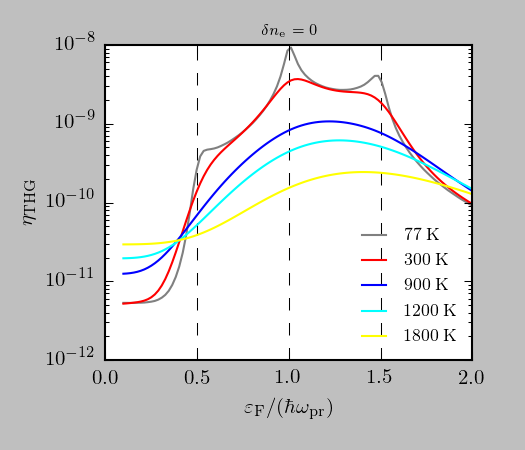

In [12]:
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap('gnuplot')
colors = ["gray", "red", "blue", "cyan", "yellow"]
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for x0 in [0.5, 1.0, 1.5, 2.0]:
    plt.axvline(x0, ls="--", c="black", lw=0.5)
for itempK,tempK in enumerate(tempK_list):
    c = cmap(itempK/len(tempK_list))
    c = colors[itempK]
    plt.plot(eF_rel_list, etaTHG[:,itempK], "-k", label=(r"$%.0f~{\rm K}$" % tempK), color=c)

plt.xlim([0.0, 2.0])
# plt.ylim([np.maximum(1.0e-15,etaTHG.min()), etaTHG.max()])
plt.ylim([1.0e-12, 1.0e-8])
plt.yscale("log")
plt.legend(frameon=False, loc="lower right", fontsize=8)
plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0])
plt.xlabel(r"$\varepsilon_{\rm F} / (\hbar \omega_{\rm pr})$")
plt.ylabel(r"$\eta_{\rm THG}$")
plt.title(r"\scriptsize $\delta n_{\rm e} = 0$")
fig.savefig("%s/thg_vs_eF_var_temp.png" % saveDir, dpi=300);

In [11]:
# Save data for the plot.
mm = np.zeros((len(eF_list)+1,len(tempK_list)+2))
mm[0,:2] = 0.0
mm[1:,0] = eF_rel_list
mm[1:,1] = eF_list
mm[0,2:] = tempK_list
mm[1:,2:] = etaTHG
np.savetxt("%s/eta_vs_eF_var_temp.csv" % saveDir, mm, delimiter=", ")

# THG vs Fermi energy at various photoexcited densities, fixed temperature

In [34]:
# List of Fermi energies, defined wrt the probe photon energy.
eF_rel_list = np.linspace(0.1, 2.0, 101)
eF_list = params["pr_eph"] * eF_rel_list
# List of photoexcited densities [nm^-2].
dnE_list = np.array([1.0e-3, 1.0e-2, 3.0e-2, 6.0e-2, 1.0e-1])
# Temperature [K].
tempK = 1800.0
temp_label = "%04.0f" % tempK

In [35]:
# Calculate THG efficiency for all photoexcited densities and Fermi energies.
etaTHG = np.zeros((len(eF_list),len(dnE_list)))
# Iterate over photoexcited density and Fermi energy.
for idnE,dnE in enumerate(dnE_list):
    for ieF,eF in enumerate(eF_list):
        # Calculate electron density [nm^-2].
        dens = gt.twobands_dens_ef_func(eF)
        # Calculate the chemical potentials.
        muC, muV = gt.photoexc_mu_func(dens, dnE, tempK)
        thg.calculate_eta(powdens=params["pr_powdens"], muC=muC, muV=muV, tempK=tempK)
        etaTHG[ieF,idnE] = thg.p["eta"]

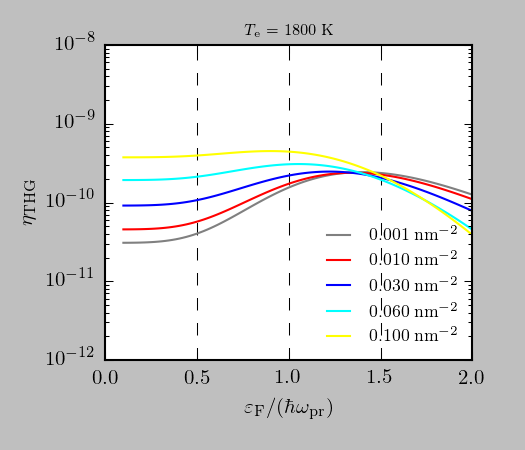

In [36]:
mpl.style.use(["classic", "latex"])
cmap = mpl.cm.get_cmap('gnuplot')
colors = ["gray", "red", "blue", "cyan", "yellow"]
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
plt.axes([0.2, 0.2, 0.7, 0.7])
for x0 in [0.5, 1.0, 1.5, 2.0]:
    plt.axvline(x0, ls="--", c="black", lw=0.5)
for idnE,dnE in enumerate(dnE_list):
    c = cmap(idnE/len(dnE_list))
    c = colors[idnE]
    plt.plot(eF_rel_list, etaTHG[:,idnE], "-k", label=(r"$%.3f~{\rm nm}^{-2}$" % dnE), color=c)

plt.xlim([0.0, 2.0])
# plt.ylim([np.maximum(1.0e-15,etaTHG.min()), etaTHG.max()])
plt.ylim([1.0e-12, 1.0e-8])
plt.yscale("log")
plt.legend(frameon=False, loc="lower right", fontsize=8)
plt.xticks([0.0, 0.5, 1.0, 1.5, 2.0])
plt.xlabel(r"$\varepsilon_{\rm F} / (\hbar \omega_{\rm pr})$")
plt.ylabel(r"$\eta_{\rm THG}$")
plt.title(r"\scriptsize $T_{\rm e} = %.0f~{\rm K}$" % tempK)
fig.savefig("%s/thg_vs_eF_var_dnE_temp_%s.png" % (saveDir, temp_label), dpi=300);

In [37]:
# Save data for the plot.
mm = np.zeros((len(eF_list)+1,len(dnE_list)+2))
mm[0,:2] = 0.0
mm[1:,0] = eF_rel_list
mm[1:,1] = eF_list
mm[0,2:] = dnE_list
mm[1:,2:] = etaTHG
np.savetxt("%s/eta_vs_eF_var_dnE_temp_%s.csv" % (saveDir, temp_label), mm, delimiter=", ")

# Colormap in the plane temperature, photoexcited density.

In [ ]:
# Set save folder.
saveDir = "./data/03/2023-08-14-10-59-04_parametric"

In [ ]:
# Fermi energy [eV].
eF = 0.100
# List of temperatures.
tempK_list = np.logspace(np.log10(30.0), np.log10(3000.0), 51)
# List of photoexcited densities.
dnE_list = np.concatenate((np.array([0.0]), np.logspace(-4.0, -1.0, 31)))

In [ ]:
# Calculate THG efficiency for all temperatures and Fermi energies.

def oneEta3(p):
    # Calculate electron density [nm^-2].
    dens = gt.twobands_dens_ef_func(p["eF"])
    # Calculate the chemical potentials.
    muC, muV = gt.photoexc_mu_func(dens, p["dnE"], p["tempK"])
    thg.calculate_eta(powdens=params["pr_powdens"], muC=muC, muV=muV, tempK=tempK)
    return (p["ij"][0], p["ij"][1], thg.p["eta"]) 

# Create a list of parameters for the function.
p3_list = []
for itempK,tempK in enumerate(tempK_list):
    for idnE,dnE in enumerate(dnE_list):
        p3_list.append({"tempK": tempK, "eF": eF, "dnE": dnE, "ij": (itempK,idnE)})

In [ ]:
with mp.Pool(24) as p:
    thg3_list = p.map(oneEta3, p3_list)

In [ ]:
thg3_df = np.zeros((len(tempK_list),len(dnE_list)))
for x in thg3_list:
    thg3_df[x[0],x[1]] = x[2]

In [ ]:
# Calculate the "differential" value of the THG, i.e. its relative variation
# with respect to the value at lowest temperature and photoexcited density,
# which (in a dynamical experiment) corresponds to the initial condition.
dthg = (thg3_df[:,1:] - thg3_df[0,0]) / thg3_df[0,0]

In [ ]:
mpl.style.use(["classic", "latex"])
fig = plt.figure(figsize=(3.5,3.0), frameon=True, dpi=150)
ax1 = plt.axes([0.2, 0.2, 0.6, 0.7])
eta = ax1.imshow(dthg[:,:].transpose(), origin="lower", aspect="auto", interpolation="none",
                 extent=(np.log10(tempK_list[0]),np.log10(tempK_list[-1]),np.log10(dnE_list[1]),np.log10(dnE_list[-1])),
                 vmin=-1.0, vmax=1.0, cmap="seismic")
tk = [30.0, 100.0, 300.0, 1000.0, 3000.0]
plt.xticks([np.log10(t) for t in tk], [r"$%d$" % t for t in tk])
tk = [-4, -3, -2, -1]
plt.yticks(tk, [r"$10^{%d}$" % (t+2) for t in tk])
plt.xlabel(r"$T_{\rm e}~[{\rm K}]$")
plt.ylabel(r"$\delta n_{\rm e}~[10^{12}\,{\rm cm}^{-2}]$")
plt.title(r"\scriptsize $\Delta {\rm THG}/{\rm THG_{0}} \quad \varepsilon_{\rm F}/\omega_{\rm pr}=%.2f$" % (eF / params["pr_eph"]))
fig.colorbar(eta)
fig.savefig("%s/deta_vs_eF_%03d.png" % (saveDir, int(eF * 1000.0)), dpi=300);

In [ ]:
# Save data for the plot.
mm = np.zeros((len(dnE_list),len(tempK_list)+1))
mm[0,1:] = tempK_list
mm[1:,0] = dnE_list[1:]
mm[1:,1:] = dthg.transpose()
np.savetxt("%s/deta_vs_eF_%03d.csv" % (saveDir, int(eF * 1000.0)), mm, delimiter=", ")